# 1. Introduction

## 1.1 Project Overview

The IEEE-CIS Fraud Detection dataset presents a challenge to build a model that can distinguish between legitimate and fraudulent transactions. Given the high dimensionality and data sparsity, a significant portion of this project is dedicated to understanding the data's underlying patterns through EDA and constructing meaningful new features through advanced feature engineering.

## 1.2 Environment Setup and Library Imports

In [1]:
!pip install xgboost
!pip install catboost

In [2]:
import os
import gc
import datetime
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupKFold
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import joblib

warnings.simplefilter("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
label_encoders = {}
frequency_maps = {}
aggregation_maps = {}
scalers = {}

# 2. Data Loading and Initial Assesment

## 2.1 Dataset Loading

In [4]:
df_train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
df_test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

In [5]:
print(f'Shape of df_train_transaction: {df_train_transaction.shape}')
print(f'Shape of df_train_identity: {df_train_identity.shape}')
print(f'Shape of df_test_transaction: {df_test_transaction.shape}')
print(f'Shape of df_test_identity: {df_test_identity.shape}')

Shape of df_train_transaction: (590540, 394)
Shape of df_train_identity: (144233, 41)
Shape of df_test_transaction: (506691, 393)
Shape of df_test_identity: (141907, 41)


In [6]:
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)

In [7]:
df_train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
df_test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


## 2.2 Merging Transaction and Identity Data

In [11]:
df_train = pd.merge(df_train_transaction, df_train_identity, on="TransactionID", how="left")
df_test = pd.merge(df_test_transaction, df_test_identity, on="TransactionID", how="left")
print(f'Shape of df_train: {df_train.shape}')
print(f'Shape of df_test: {df_test.shape}')

Shape of df_train: (590540, 434)
Shape of df_test: (506691, 433)


In [12]:
pd.set_option('display.max_columns', None)      
pd.set_option('display.width', None)           
pd.set_option('display.max_colwidth', None)   

print(df_train)


        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5   card6  addr1  addr2  dist1  \
0       13926    NaN

In [13]:
print(df_train.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

## 2.3 Initial Inspection

In [14]:
print(df_train.isnull().sum())
print(f'There are {df_train.isnull().any().sum()} columns with missing values')

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64
There are 414 columns with missing values


In [15]:
print(df_test.isnull().sum())
print(f'There are {df_test.isnull().any().sum()} columns with missing values')

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_36             369714
id_37             369714
id_38             369714
DeviceType        369760
DeviceInfo        391634
Length: 433, dtype: int64
There are 385 columns with missing values


# 3. EDA

## 3.1 Target Variable Analysis: Class Imbalance

In [16]:
counts = df_train['isFraud'].value_counts()
percentages = df_train['isFraud'].value_counts(normalize=True) * 100

imbalance_df_train = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

print(imbalance_df_train)

          Count  Percentage
isFraud                    
0        569877        96.5
1         20663         3.5


## 3.2 TransactionDT Distribution Visualization 

TransactionDT bukan merupakan timestamp melainkan waktu dalam seconds sejak titik waktu awal yang tidak diketahui

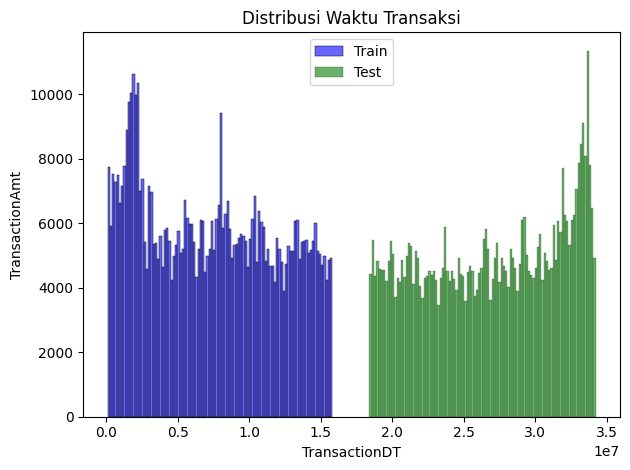

In [17]:
sns.histplot(df_train['TransactionDT'], label='Train', color='blue', alpha=0.6, bins=100)
sns.histplot(df_test['TransactionDT'], label='Test', color='green', alpha=0.6, bins=100)

plt.title('Distribusi Waktu Transaksi', fontsize=12)
plt.xlabel('TransactionDT', fontsize=10)
plt.ylabel('TransactionAmt', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

- Time Based Split untuk atau validasi K-Fold Cross Validation berdasarkan waktu
- Terdapat lonjakan data bisa jadi aktivitas abnormal

## 3.3 Day of Week Transaction Volume Analysis

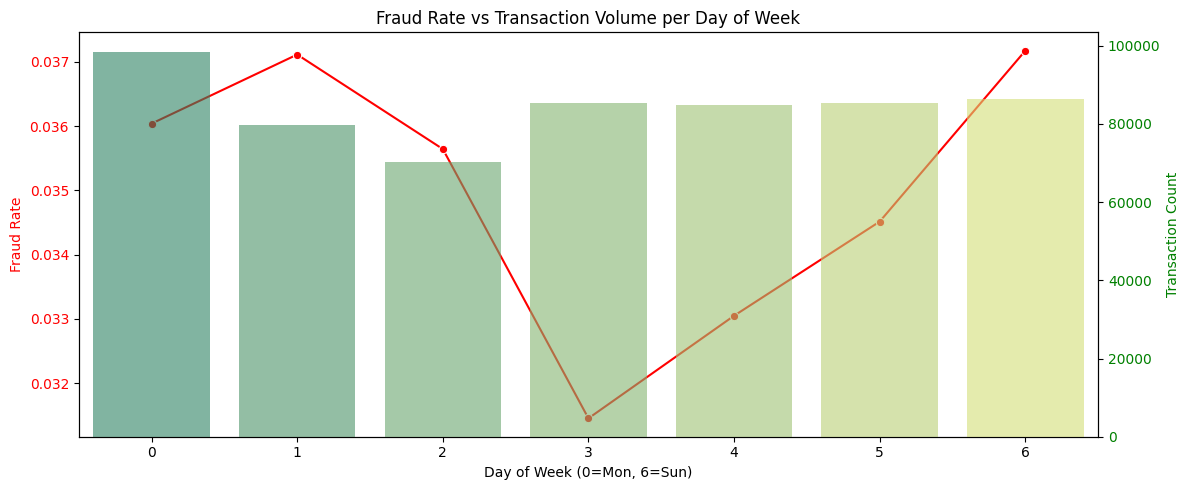

In [18]:
df_train['dayofweek'] = ((df_train['TransactionDT'] // (60 * 60 * 24)) - 1) % 7

fraud_ratio = df_train.groupby('dayofweek')['isFraud'].mean().reset_index() # in percentage
fraud_ratio.rename(columns={'isFraud': 'Fraud Rate'}, inplace=True)

transaction_count = df_train.groupby('dayofweek')['TransactionID'].count().reset_index()
transaction_count.rename(columns={'TransactionID': 'Transaction Count'}, inplace=True)

summary_df = pd.merge(fraud_ratio, transaction_count, on='dayofweek')
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot garis -> Fraud Rate
sns.lineplot(data=summary_df, x='dayofweek', y='Fraud Rate', color='red', marker='o', ax=ax1)
ax1.set_ylabel('Fraud Rate', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(range(7))
ax1.set_xlabel('Day of Week (0=Mon, 6=Sun)')
ax1.set_title('Fraud Rate vs Transaction Volume per Day of Week')

# Plot batang -> Transaction Count
ax2 = ax1.twinx()
sns.barplot(data=summary_df, x='dayofweek', y='Transaction Count', palette='summer', alpha=0.6, ax=ax2)
ax2.set_ylabel('Transaction Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.tight_layout()
plt.show()

## 3.4 Hourly Transaction Volume Analysis

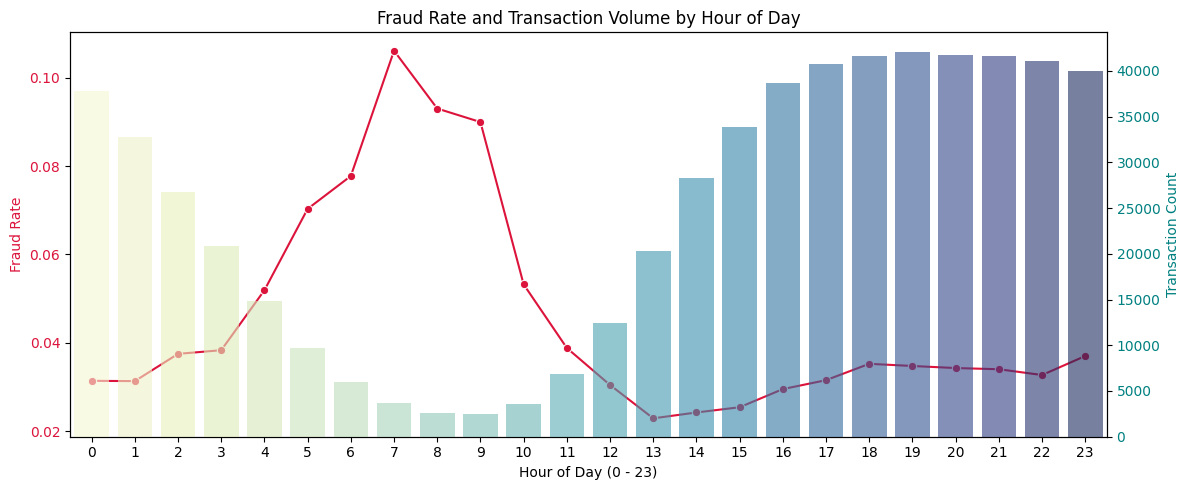

In [19]:
df_train['hour'] = (df_train['TransactionDT'] // (60 * 60)) % 24

fraud_rate_by_hour = df_train.groupby('hour')['isFraud'].mean().reset_index()
fraud_rate_by_hour.rename(columns={'isFraud': 'Fraud Rate'}, inplace=True)

transaction_count_by_hour = df_train.groupby('hour')['TransactionID'].count().reset_index()
transaction_count_by_hour.rename(columns={'TransactionID': 'Transaction Count'}, inplace=True)

hourly_stats = pd.merge(fraud_rate_by_hour, transaction_count_by_hour, on='hour')
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot garis -> Fraud Rate
sns.lineplot(
    data=hourly_stats,
    x='hour',
    y='Fraud Rate',
    color='crimson',
    marker='o',
    ax=ax1
)
ax1.set_ylabel('Fraud Rate', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.set_xlabel('Hour of Day (0 - 23)')
ax1.set_title('Fraud Rate and Transaction Volume by Hour of Day')

# Plot batang -> Transaction Count
ax2 = ax1.twinx()
sns.barplot(
    data=hourly_stats,
    x='hour',
    y='Transaction Count',
    palette='YlGnBu',
    alpha=0.6,
    ax=ax2
)
ax2.set_ylabel('Transaction Count', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')
plt.tight_layout()
plt.show()

## 3.5 Hourly Fraud Rate Categorization

In [20]:
df_train['hour'] = (df_train['TransactionDT'] // (60 * 60)) % 24
fraud_rate_by_hour = df_train.groupby('hour')['isFraud'].mean().reset_index()
fraud_rate_by_hour.rename(columns={'isFraud': 'Fraud Rate'}, inplace=True)
transaction_count_by_hour = df_train.groupby('hour')['TransactionID'].count().reset_index()
transaction_count_by_hour.rename(columns={'TransactionID': 'Transaction Count'}, inplace=True)

hourly_stats = pd.merge(fraud_rate_by_hour, transaction_count_by_hour, on='hour')

desc = hourly_stats['Fraud Rate'].describe()
q1, q2, q3 = desc['25%'], desc['50%'], desc['75%']

def categorize_fraud_rate(rate):
    if rate < q1:
        return 'Very Low'
    elif rate < q2:
        return 'Low'
    elif rate < q3:
        return 'Medium'
    else:
        return 'High'

hourly_stats['Fraud Risk Level'] = hourly_stats['Fraud Rate'].apply(categorize_fraud_rate)

print("Analisis Fraud Rate per Jam Transaksi")
print(hourly_stats.sort_values('hour').to_string(index=False))

Analisis Fraud Rate per Jam Transaksi
 hour  Fraud Rate  Transaction Count Fraud Risk Level
    0    0.031380              37795              Low
    1    0.031314              32797         Very Low
    2    0.037483              26732           Medium
    3    0.038314              20802           Medium
    4    0.051890              14839           Medium
    5    0.070302               9701             High
    6    0.077743               6007             High
    7    0.106102               3704             High
    8    0.093014               2591             High
    9    0.089956               2479             High
   10    0.053212               3627             High
   11    0.038816               6827           Medium
   12    0.030439              12451         Very Low
   13    0.022889              20315         Very Low
   14    0.024216              28328         Very Low
   15    0.025399              33859         Very Low
   16    0.029511              38698        

## 3.6 Hourly Average Transaction Amount Analysis

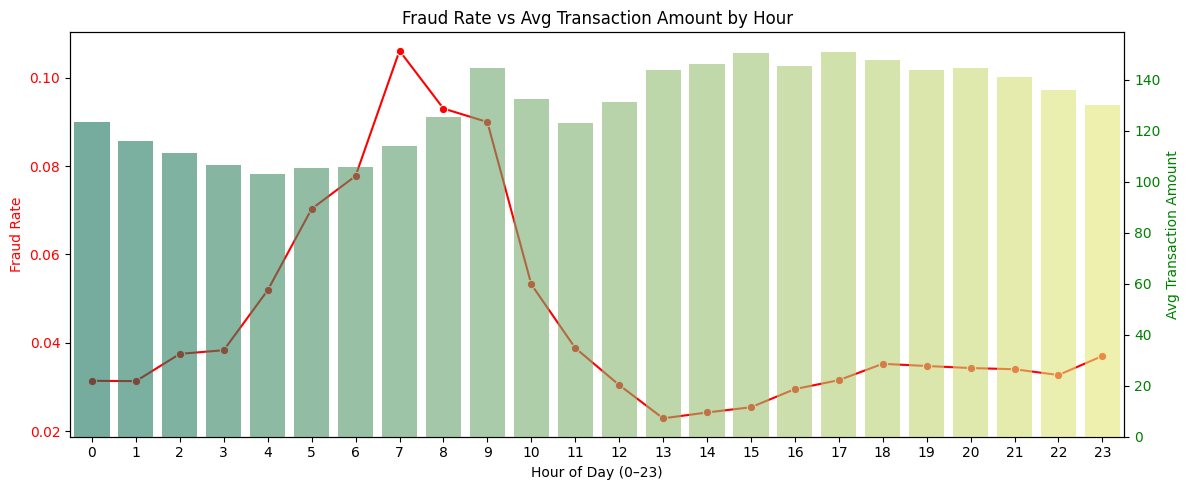

In [21]:
df_train['hour'] = (df_train['TransactionDT'] // (60 * 60)) % 24

fraud_rate = df_train.groupby('hour')['isFraud'].mean().reset_index()
fraud_rate.rename(columns={'isFraud': 'Fraud Rate'}, inplace=True)

avg_amount = df_train.groupby('hour')['TransactionAmt'].mean().reset_index()
avg_amount.rename(columns={'TransactionAmt': 'Avg Transaction Amount'}, inplace=True)

hourly_analysis = pd.merge(fraud_rate, avg_amount, on='hour')

fig, ax1 = plt.subplots(figsize=(12, 5))

# Garis -> fraud rate
sns.lineplot(data=hourly_analysis, x='hour', y='Fraud Rate', color='red', marker='o', ax=ax1)
ax1.set_ylabel('Fraud Rate', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Hour of Day (0–23)')
ax1.set_title('Fraud Rate vs Avg Transaction Amount by Hour')

# Bar -> rata-rata nominal transaksi 
ax2 = ax1.twinx()
sns.barplot(data=hourly_analysis, x='hour', y='Avg Transaction Amount', palette='summer', alpha=0.6, ax=ax2)
ax2.set_ylabel('Avg Transaction Amount', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.tight_layout()
plt.show()

## 3.7 Transaction Amount vs Time Analysis

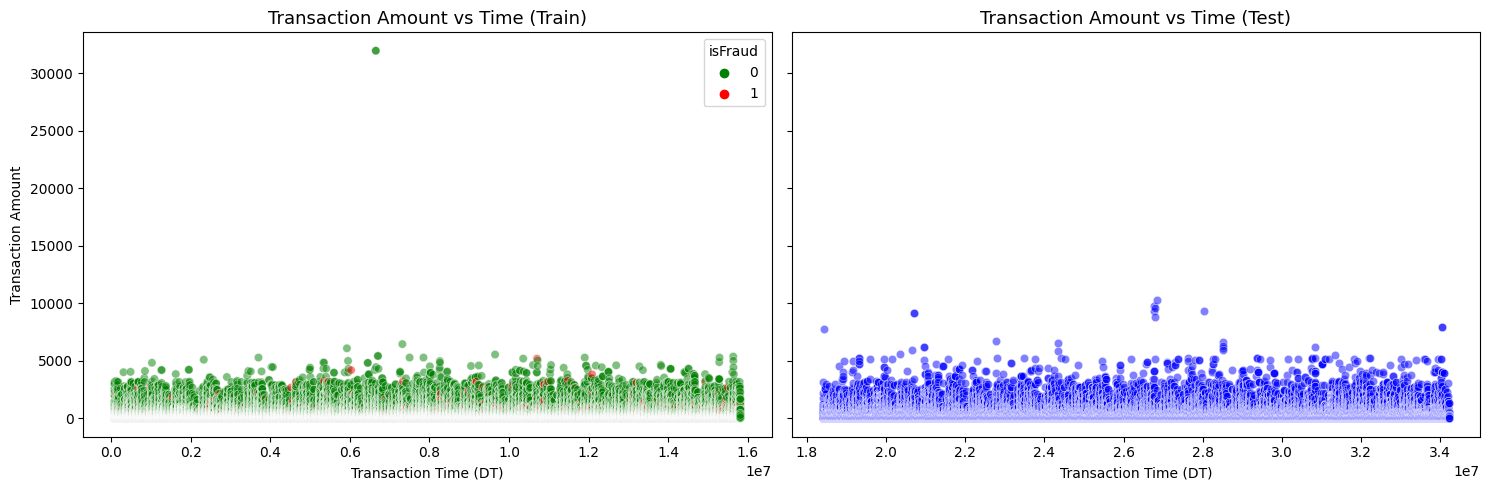

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.scatterplot(
    data=df_train,
    x='TransactionDT',
    y='TransactionAmt',
    hue='isFraud',
    palette={0: 'green', 1: 'red'},
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title('Transaction Amount vs Time (Train)', fontsize=13)
axes[0].set_xlabel('Transaction Time (DT)')
axes[0].set_ylabel('Transaction Amount')

sns.scatterplot(
    data=df_test,
    x='TransactionDT',
    y='TransactionAmt',
    color='blue',
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Transaction Amount vs Time (Test)', fontsize=13)
axes[1].set_xlabel('Transaction Time (DT)')
axes[1].set_ylabel('') 
plt.tight_layout()
plt.show()

Outlier > 30000. Better remove outlier

# 4. Feature Engineering

## 4.1. Initial Column Identification and Selection

In [23]:
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])

type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]

v_cols_included = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']



In [24]:
drop_cols = [col for col in df_train.columns if col[0] == 'V' and col not in v_cols_included]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols + ['dayofweek', 'hour'])
df_test = df_test.drop(columns=drop_cols)

dropping 211 columns


## 4.2. Initial Preprocessing: Encoding and Normalization

In [25]:
# Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


13474

In [26]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # dff = pd.concat([X_train[col],X_test[col]])
        # dff, uniques = pd.factorize(dff, sort=True)
        # label_encoders[col] = uniques
            
        # X_train[col] = dff[:len(X_train)].astype('int16')
        # X_test[col] = dff[len(X_train):].astype('int16')
        le = LabelEncoder()
    
        dff = pd.concat([X_train[col], X_test[col]]).astype(str)
        le.fit(dff)
    
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    
        label_encoders[col] = le  

In [27]:
# normalize d cols
norm_cols =  [15, 4, 2, 11, 10]
for i in range(1,16):
  if i in norm_cols:
      X_train['D'+str(i)+'n'] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
      X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

# hour column
X_train['hour'] = (X_train['TransactionDT']//(60*60))%24
X_test['hour'] = (X_test['TransactionDT']//(60*60))%24


## 4.3. Interaction and Frequency Feature Creation

In [28]:
# combines train and test dataframes and then encodes
def frequency_encode(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        frequency_maps[col] = vc
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(f"'{nm}'",", ",end=" ")

# label encode a particular column
def label_encode(df_train,df_test,col):
    dff = pd.concat([df_train[col],df_test[col]])
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max() > 32000:
        df_train[col] = dff[0:len(df_train)].astype('int32')
        df_test[col] = dff[len(df_train):].astype('int32')
    else:
        df_train[col] = dff[0:len(df_train)].astype('int16')
        df_test[col] = dff[len(df_train):].astype('int16')
    del dff,_
    gc.collect()

def combine_cols(col1,col2,df_train,df_test):
    name = col1 + '_' + col2
    df_train[name] = df_train[col1].astype(str)+'_'+df_train[col2].astype(str)
    df_test[name] = df_test[col1].astype(str)+'_'+df_test[col2].astype(str)
    label_encode(df_train,df_test,name)
    print(f"'{name}'",", ",end=" ")

In [29]:
new_cols =['card4_addr1_R_emaildomain', 'card2_FE','card1_FE', 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1','card4_addr1_P_emaildomain_FE']

# 'card2_FE','card1_FE'
frequency_encode(X_train,X_test,['card1','card2'])

# 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1'
combine_cols('card1','addr1',X_train,X_test)
combine_cols('card3','addr1',X_train,X_test)
combine_cols('card1_addr1','R_emaildomain',X_train,X_test)
combine_cols('card3_addr1','P_emaildomain',X_train,X_test)

#'card4_addr1_R_emaildomain , 'card4_addr1_P_emaildomain_FE
combine_cols('card4','addr1',X_train,X_test)
combine_cols('card4_addr1','R_emaildomain',X_train,X_test)
combine_cols('card4_addr1','P_emaildomain',X_train,X_test)
frequency_encode(X_train,X_test,['card4_addr1_P_emaildomain'])

drop_cols = ['card3_addr1','card4_addr1','card4_addr1_P_emaildomain']
print('\n\n')
print(drop_cols)

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

'card1_FE' ,  'card2_FE' ,  'card1_addr1' ,  'card3_addr1' ,  'card1_addr1_R_emaildomain' ,  'card3_addr1_P_emaildomain' ,  'card4_addr1' ,  'card4_addr1_R_emaildomain' ,  'card4_addr1_P_emaildomain' ,  'card4_addr1_P_emaildomain_FE' ,  


['card3_addr1', 'card4_addr1', 'card4_addr1_P_emaildomain']


In [30]:
def aggregate_cols(num_cols,cat_cols,aggs,X_train=X_train,X_test=X_test,use_nan_value=True,fill_nan=True):
    for num_col in num_cols:
        for cat_col in cat_cols:
            for agg_type in aggs:
                cols = [num_col,cat_col]
                new_col_name = num_col + '_' + cat_col + '_' + agg_type
                df = pd.concat([X_train[cols],X_test[cols]])
                if use_nan_value: 
                    df.loc[df[num_col]==-1,num_col] = np.nan
            
                tmp_df = df.groupby(by=[cat_col])[num_col].agg([agg_type])[agg_type].reset_index().rename(
                                                        columns={agg_type: new_col_name})
                tmp_df.index = list(tmp_df[cat_col])
                tmp_dict = tmp_df[new_col_name].to_dict()
                aggregation_maps[new_col_name] = tmp_dict
                X_train[new_col_name] = X_train[cat_col].map(tmp_dict).astype('float32')
                X_test[new_col_name]  = X_test[cat_col].map(tmp_dict).astype('float32')
            
                if fill_nan:
                    X_train[new_col_name].fillna(-1,inplace=True)
                    X_test[new_col_name].fillna(-1,inplace=True)
                
                print(f"'{new_col_name}'",", ",end=" ")


def aggregate_cols_cat(num_cols,cat_cols,X_train=X_train,X_test=X_test):
  for num_col in num_cols:
    for cat_col in cat_cols:
        cols = [num_col,cat_col]
        new_col_name = num_col + '_' + cat_col + '_ct'
        df = pd.concat([X_train[cols],X_test[cols]])
        mp = df.groupby(cat_col)[num_col].agg(['nunique'])['nunique'].to_dict()
        X_train[new_col_name] = X_train[cat_col].map(mp).astype('float32')
        X_test[new_col_name] = X_test[cat_col].map(mp).astype('float32')
        print(f"'{new_col_name}'",", ",end=" ")

In [31]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 


X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

## 4.4. Advanced Aggregation Feature Creation

In [32]:
X_train['uid2'] = X_train['card1_addr1']
X_test['uid2'] = X_test['card1_addr1']

In [33]:
# FREQUENCY ENCODE UID
frequency_encode(X_train,X_test,['uid2'])
aggregate_cols(['M'+str(x) for x in range(1,10)],['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)

'uid2_FE' ,  'M1_uid2_mean' ,  'M1_uid2_std' ,  'M2_uid2_mean' ,  'M2_uid2_std' ,  'M3_uid2_mean' ,  'M3_uid2_std' ,  'M4_uid2_mean' ,  'M4_uid2_std' ,  'M5_uid2_mean' ,  'M5_uid2_std' ,  'M6_uid2_mean' ,  'M6_uid2_std' ,  'M7_uid2_mean' ,  'M7_uid2_std' ,  'M8_uid2_mean' ,  'M8_uid2_std' ,  'M9_uid2_mean' ,  'M9_uid2_std' ,  

In [34]:
# AGGREGATE 
tmp = ['D'+str(i) for i in range(1,16)]
tmp.append('TransactionAmt')
aggregate_cols(tmp,['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)

'D1_uid2_mean' ,  'D1_uid2_std' ,  'D2_uid2_mean' ,  'D2_uid2_std' ,  'D3_uid2_mean' ,  'D3_uid2_std' ,  'D4_uid2_mean' ,  'D4_uid2_std' ,  'D5_uid2_mean' ,  'D5_uid2_std' ,  'D6_uid2_mean' ,  'D6_uid2_std' ,  'D7_uid2_mean' ,  'D7_uid2_std' ,  'D8_uid2_mean' ,  'D8_uid2_std' ,  'D9_uid2_mean' ,  'D9_uid2_std' ,  'D10_uid2_mean' ,  'D10_uid2_std' ,  'D11_uid2_mean' ,  'D11_uid2_std' ,  'D12_uid2_mean' ,  'D12_uid2_std' ,  'D13_uid2_mean' ,  'D13_uid2_std' ,  'D14_uid2_mean' ,  'D14_uid2_std' ,  'D15_uid2_mean' ,  'D15_uid2_std' ,  'TransactionAmt_uid2_mean' ,  'TransactionAmt_uid2_std' ,  

In [35]:
tmp = ['C'+str(i) for i in range(1,15)]
aggregate_cols(tmp,['uid2'],['mean','std'],use_nan_value=True,fill_nan=True)

'C1_uid2_mean' ,  'C1_uid2_std' ,  'C2_uid2_mean' ,  'C2_uid2_std' ,  'C3_uid2_mean' ,  'C3_uid2_std' ,  'C4_uid2_mean' ,  'C4_uid2_std' ,  'C5_uid2_mean' ,  'C5_uid2_std' ,  'C6_uid2_mean' ,  'C6_uid2_std' ,  'C7_uid2_mean' ,  'C7_uid2_std' ,  'C8_uid2_mean' ,  'C8_uid2_std' ,  'C9_uid2_mean' ,  'C9_uid2_std' ,  'C10_uid2_mean' ,  'C10_uid2_std' ,  'C11_uid2_mean' ,  'C11_uid2_std' ,  'C12_uid2_mean' ,  'C12_uid2_std' ,  'C13_uid2_mean' ,  'C13_uid2_std' ,  'C14_uid2_mean' ,  'C14_uid2_std' ,  

In [36]:
aggregate_cols(['M9', 'M4', 'TransactionAmt'],['uid2'],['mean'],use_nan_value=True,fill_nan=True)
aggregate_cols(['M6', 'M9', 'M8'],['uid2'],['std'],use_nan_value=True,fill_nan=True)

'M9_uid2_mean' ,  'M4_uid2_mean' ,  'TransactionAmt_uid2_mean' ,  'M6_uid2_std' ,  'M9_uid2_std' ,  'M8_uid2_std' ,  

# 5. Feature Selection

## 5.1. Feature Selection Strategy

In [37]:
new_feat1 = ['uid2_FE' ,  'M1_uid2_mean' ,  'M1_uid2_std' ,  'M2_uid2_mean' ,  'M2_uid2_std' ,  'M3_uid2_mean' ,  'M3_uid2_std' ,  'M4_uid2_mean' ,  'M4_uid2_std' ,  'M5_uid2_mean' ,
             'M5_uid2_std' ,  'M6_uid2_mean' ,  'M6_uid2_std' ,  'M7_uid2_mean' ,  'M7_uid2_std' ,  'M8_uid2_mean' ,  'M8_uid2_std' ,  'M9_uid2_mean' ,  'M9_uid2_std' ]

new_feat2 = ['D1_uid2_mean' ,  'D1_uid2_std' ,  'D2_uid2_mean' ,  'D2_uid2_std' ,  'D3_uid2_mean' ,  'D3_uid2_std' ,  'D4_uid2_mean' ,  'D4_uid2_std' ,  'D5_uid2_mean' ,  'D5_uid2_std' ,  'D6_uid2_mean' ,  
             'D6_uid2_std' ,  'D7_uid2_mean' ,  'D7_uid2_std' ,  'D8_uid2_mean' ,  'D8_uid2_std' ,  'D9_uid2_mean' ,  'D9_uid2_std' ,  'D10_uid2_mean' ,  'D10_uid2_std' ,  'D11_uid2_mean' ,  'D11_uid2_std' ,  'D12_uid2_mean' ,
             'D12_uid2_std' ,  'D13_uid2_mean' ,  'D13_uid2_std' ,  'D14_uid2_mean' ,  'D14_uid2_std' ,  'D15_uid2_mean' ,  'D15_uid2_std' ,  'TransactionAmt_uid2_mean' ,  'TransactionAmt_uid2_std' ,  ]

new_feat3 = ['C1_uid2_mean' ,  'C1_uid2_std' ,  'C2_uid2_mean' ,  'C2_uid2_std' ,  'C3_uid2_mean' ,  'C3_uid2_std' ,  'C4_uid2_mean' ,  'C4_uid2_std' ,  'C5_uid2_mean' ,  'C5_uid2_std' , 
             'C6_uid2_mean' ,  'C6_uid2_std' ,  'C7_uid2_mean' ,  'C7_uid2_std' ,  'C8_uid2_mean' ,  'C8_uid2_std' ,  'C9_uid2_mean' ,
             'C9_uid2_std' ,  'C10_uid2_mean' ,  'C10_uid2_std' ,  'C11_uid2_mean' ,  'C11_uid2_std' ,  'C12_uid2_mean' ,  'C12_uid2_std' ,  'C13_uid2_mean' ,
             'C13_uid2_std' ,  'C14_uid2_mean' ,  'C14_uid2_std' , ]


new_feats = new_feat1 + new_feat2 + new_feat3
print(len(new_feats))

79


## 5.2. Forward Feature Selection Implementation

In [38]:
def forward_feat_selection(new_cols,old_cols,best_score):
    print(f'Forward feature selection on {len(new_cols)} features <-->  current best score {best_score} with {len(old_cols)} features')
    iteration = 1
    iteration_best_col = None
    # list of additional columns
    best_cols = []
    while iteration <= len(new_cols):
        for j,col in enumerate(new_cols):
            print(f'Model no: {iteration}_{(j+1)}')
            print('--'*40)
            if col not in best_cols:
                current_cols = old_cols.copy()
                # adding new feature
                best_cols.append(col) 
                print(f'Adding new features: {best_cols}')
                current_cols.extend([c for c in best_cols])        
                current_score = model(X_train,y_train,current_cols)

                if current_score > best_score:
                    print(f'Score improved on adding {col} new best score {current_score}')
                    iteration_best_col = col
                    best_score = current_score
                else:
                    print(f'Score not improved on adding {col}')
            
                best_cols.remove(col)

            else:
                print(f'Skipping {col} already an selected column')
        
            # print('--'*40)

        iteration += 1
        if iteration_best_col is not None:
            best_cols.append(iteration_best_col)
            print(f'Best col in this iteration {iteration_best_col}, --->   current best cols: {best_cols}')
            iteration_best_col = None
                  
        else:
            print('None of the columns improving the score in this iteration')
            # print('###'*40)
            break
      
        # print('###'*40)

    print(f'Useful new features : {best_cols}')
    print(f'Best score : {best_score}')


In [39]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['DT_M','day','uid','uid2'])
norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)

cols = [col for col in X_train.columns if col not in rem_cols]
len(cols)

307

## 5.3 Feature Selection Results

In [40]:
# old_cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]

# forward_feat_selection(new_cols=new_feat1,old_cols=old_cols,best_score=0.82)

In [41]:
# old_cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]

# old_cols.extend(['M6_uid2_std', 'M9_uid2_mean', 'M9_uid2_std', 'M8_uid2_std', 'M4_uid2_mean'])
# forward_feat_selection(new_cols=new_feat2,old_cols=old_cols,best_score=0.94807226432861)

In [42]:
# old_cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]
# old_cols.extend(['M6_uid2_std', 'M9_uid2_mean', 'M9_uid2_std', 'M8_uid2_std', 'M4_uid2_mean', 'TransactionAmt_uid2_mean'])
# forward_feat_selection(new_cols=new_feat3,old_cols=old_cols,best_score=0.9487853537177315)

# 6. Model Implementation and Cross-Validation

## 6.1. Final Feature Scaling

In [43]:
X_train['uid2'] = X_train['card1_addr1']
X_test['uid2'] = X_test['card1_addr1']

aggregate_cols(['M9','M5','D2','D15','C13','C9','C1','C11'],['uid'],['mean'],use_nan_value=True,fill_nan=True)
aggregate_cols(['TransactionAmt'],['uid'],['std'],use_nan_value=True,fill_nan=True)

'M9_uid_mean' ,  'M5_uid_mean' ,  'D2_uid_mean' ,  'D15_uid_mean' ,  'C13_uid_mean' ,  'C9_uid_mean' ,  'C1_uid_mean' ,  'C11_uid_mean' ,  'TransactionAmt_uid_std' ,  

In [44]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['DT_M','day','uid','uid2'])

norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)
rem_cols.extend(['id_07','id_08'])
rem_cols.extend(['id_'+str(i) for i in range(21,28)])


cols = [col for col in X_train.columns if col not in rem_cols]
print(len(cols))

for col in cols:
    if col not in cat_cols:
        scaler = MinMaxScaler()
        X_train[[col]] = scaler.fit_transform(X_train[[col]])
        X_test[[col]] = scaler.transform(X_test[[col]])
        scalers[col] = scaler  

307


In [45]:
print("Kolom digunakan untuk training (cols):", cols)

Kolom digunakan untuk training (cols): ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D3', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210', 'V21

## 6.2. Model Training and Evaluation

In [43]:
# 75-25 split
#0.934
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )
model = clf.fit(X_train.loc[idx_train,cols], y_train[idx_train], 
    eval_set=[(X_train.loc[idx_validation,cols],y_train[idx_validation])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.81883
[50]	validation_0-auc:0.89973
[100]	validation_0-auc:0.91768
[150]	validation_0-auc:0.92959
[200]	validation_0-auc:0.93706
[250]	validation_0-auc:0.94021
[300]	validation_0-auc:0.94254
[350]	validation_0-auc:0.94374
[400]	validation_0-auc:0.94438
[450]	validation_0-auc:0.94471
[500]	validation_0-auc:0.94491
[550]	validation_0-auc:0.94459
[598]	validation_0-auc:0.94439


## 6.3 Final Model Training

In [105]:
x_train = X_train
x_test = X_test

tr_pred = np.zeros(len(x_train))
preds = np.zeros(len(x_test))

skf = GroupKFold(n_splits=6)

# Inisialisasi pencatat model terbaik
best_auc = 0
best_model = None
best_fold = -1

for i, (idx_train, idx_validation) in enumerate(skf.split(x_train, y_train, groups=x_train['DT_M'])):
    month = x_train.iloc[idx_validation]['DT_M'].iloc[0]
    print(f'Fold {i} withholding month {month}')
    print(' rows of train =', len(idx_train), 'rows of holdout =', len(idx_validation))
    
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.002,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        tree_method='gpu_hist' 
    )        
    
    clf.fit(
        x_train[cols].iloc[idx_train], 
        y_train.iloc[idx_train], 
        eval_set=[(x_train[cols].iloc[idx_validation], y_train.iloc[idx_validation])],
        verbose=250, 
        early_stopping_rounds=200
    )

    val_pred = clf.predict_proba(x_train[cols].iloc[idx_validation])[:, 1]
    auc = roc_auc_score(y_train.iloc[idx_validation], val_pred)
    print(f'Fold {i} AUC: {auc:.6f}')

    tr_pred[idx_validation] = val_pred
    preds += clf.predict_proba(x_test[cols])[:, 1] / skf.n_splits

    # Simpan model jika AUC-nya terbaik
    if auc > best_auc:
        best_auc = auc
        best_model = clf
        best_fold = i

    del clf
    gc.collect()

print('#' * 20)
print('Best Fold:', best_fold)
print('Best AUC:', best_auc)
print('Total CV AUC =', roc_auc_score(y_train, tr_pred))

# Simpan model terbaik
os.makedirs("xgb_models", exist_ok=True)
best_model.save_model(f"xgb_models/xgb_best_fold_{best_fold}.json")
joblib.dump(best_model, f"xgb_models/xgb_best_fold_{best_fold}.pkl")
print(f"Best model from fold {best_fold} saved.")


Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.77192
[250]	validation_0-auc:0.87832
[500]	validation_0-auc:0.88690
[750]	validation_0-auc:0.89381
[1000]	validation_0-auc:0.90072
[1250]	validation_0-auc:0.90531
[1500]	validation_0-auc:0.90941
[1750]	validation_0-auc:0.91209
[2000]	validation_0-auc:0.91408
[2250]	validation_0-auc:0.91551
[2500]	validation_0-auc:0.91637
[2750]	validation_0-auc:0.91722
[3000]	validation_0-auc:0.91782
[3250]	validation_0-auc:0.91853
[3500]	validation_0-auc:0.91888
[3750]	validation_0-auc:0.91923
[4000]	validation_0-auc:0.91957
[4250]	validation_0-auc:0.91970
[4500]	validation_0-auc:0.91990
[4750]	validation_0-auc:0.92001
[4999]	validation_0-auc:0.92004
Fold 0 AUC: 0.920041
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.84042
[250]	validation_0-auc:0.90360
[500]	validation_0-auc:0.91449
[750]	validation_0-auc:0.92294
[1000]	validation_0-auc:0.93038
[1250

In [64]:
tr_pred_cat = np.zeros(len(x_train))
preds_cat = np.zeros(len(x_test))

skf = GroupKFold(n_splits=6)
for i, (idx_train, idx_validation) in enumerate(skf.split(x_train, y_train, groups=x_train['DT_M']) ):
    month = x_train.iloc[idx_validation]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idx_train),'rows of holdout =',len(idx_validation))
    model = CatBoostClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.002,
        eval_metric='AUC',
        metric_period=5,
        verbose=250,
        task_type='GPU'
    )        
    
    model.fit(x_train[cols].iloc[idx_train], y_train.iloc[idx_train], 
            eval_set=[(x_train[cols].iloc[idx_validation],y_train.iloc[idx_validation])],
            verbose=250, early_stopping_rounds=200)
    tr_pred[idx_validation] += model.predict_proba(x_train[cols].iloc[idx_validation])[:,1]
    preds += model.predict_proba(x_test[cols])[:,1]/skf.n_splits
    gc.collect()

print('[CatBoost] AUC=', roc_auc_score(y_train, tr_pred_cat))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
0:	test: 0.7740655	best: 0.7740655 (0)	total: 114ms	remaining: 9m 31s
bestTest = 0.8308487236
bestIteration = 10
Shrink model to first 11 iterations.
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
0:	test: 0.8181784	best: 0.8181784 (0)	total: 132ms	remaining: 11m 1s
250:	test: 0.8635370	best: 0.8635370 (250)	total: 28.9s	remaining: 9m 7s
500:	test: 0.8736097	best: 0.8736097 (500)	total: 57.8s	remaining: 8m 39s
750:	test: 0.8842094	best: 0.8842094 (750)	total: 1m 27s	remaining: 8m 13s
1000:	test: 0.8933244	best: 0.8933244 (1000)	total: 1m 57s	remaining: 7m 48s
1250:	test: 0.8996797	best: 0.8996797 (1250)	total: 2m 27s	remaining: 7m 21s
1500:	test: 0.9044169	best: 0.9044169 (1500)	total: 2m 57s	remaining: 6m 53s
1750:	test: 0.9081571	best: 0.9081571 (1750)	total: 3m 27s	remaining: 6m 24s
2000:	test: 0.9110496	best: 0.9110501 (1999)	total: 3m 57s	remaining: 5m 55s
2250:	test: 0.91354

In [ ]:
# Save XGBoost model to a file
model.save_model("xgboost_fraud_model.json")

In [67]:
tr_pred_rf = np.zeros(len(x_train))
preds_rf = np.zeros(len(x_test))

skf = GroupKFold(n_splits=6)
for i, (idx_train, idx_validation) in enumerate(skf.split(x_train, y_train, groups=x_train['DT_M'])):
    month = x_train.iloc[idx_validation]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print(' rows of train =', len(idx_train), 'rows of holdout =', len(idx_validation))

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )        

    model.fit(
        x_train[cols].iloc[idx_train], 
        y_train.iloc[idx_train]
    )

    tr_pred_rf[idx_validation] += model.predict_proba(x_train[cols].iloc[idx_validation])[:, 1]
    preds_rf += model.predict_proba(x_test[cols])[:, 1] / skf.n_splits
    gc.collect()

print('[RandomForest] AUC=', roc_auc_score(y_train, tr_pred_rf))


Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
Fold 3 withholding month 17
 rows of train = 501214 rows of holdout = 89326
Fold 4 withholding month 14
 rows of train = 504519 rows of holdout = 86021
Fold 5 withholding month 16
 rows of train = 506885 rows of holdout = 83655
[RandomForest] AUC= 0.9101542811672992


In [68]:
joblib.dump(model, 'random_forest_model.joblib')
print("Model saved as 'random_forest_model.joblib'")


Model saved as 'random_forest_model.joblib'


In [123]:
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("frequency_maps.pkl", "wb") as f:
    pickle.dump(frequency_maps, f)

with open("aggregation_maps.pkl", "wb") as f:
    pickle.dump(aggregation_maps, f)

with open("scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)

print("Semua file berhasil disimpan!")

Semua file berhasil disimpan!
